In [138]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import silhouette_score
import plotly.express as px
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [139]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)


ID                    0
Name                  0
Year Published        0
Min Players           0
Max Players           0
Play Time             0
Min Age               0
Users Rated           0
Rating Average        0
BGG Rank              0
Complexity Average    0
Owned Users           0
Mechanics             0
Domains               0
Cluster               0
dtype: int64


In [162]:
df = pd.read_csv("cleaned_bgg_dataset.csv")

df[['Name','Mechanics']].head()

,Name,Mechanics
0,Gloomhaven,"['Action Queue', 'Action Retrieval', 'Campaign..."
1,Pandemic Legacy: Season 1,"['Action Points', 'Cooperative Game', 'Hand Ma..."
2,Brass: Birmingham,"['Hand Management', 'Income', 'Loans', 'Market..."
3,Terraforming Mars,"['Card Drafting', 'Drafting', 'End Game Bonuse..."
4,Twilight Imperium: Fourth Edition,"['Action Drafting', 'Area Majority / Influence..."


In [163]:
print(df.columns)

Index(['ID', 'Name', 'Year Published', 'Min Players', 'Max Players',
       'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 'BGG Rank',
       'Complexity Average', 'Owned Users', 'Mechanics', 'Domains'],
      dtype='object')


In [164]:
print(df['Mechanics'].iloc[0])
print(df['Mechanics'].iloc[1])

['Action Queue', 'Action Retrieval', 'Campaign / Battle Card Driven', 'Card Play Conflict Resolution', 'Communication Limits', 'Cooperative Game', 'Deck Construction', 'Deck Bag and Pool Building', 'Grid Movement', 'Hand Management', 'Hexagon Grid', 'Legacy Game', 'Modular Board', 'Once-Per-Game Abilities', 'Scenario / Mission / Campaign Game', 'Simultaneous Action Selection', 'Solo / Solitaire Game', 'Storytelling', 'Variable Player Powers']
['Action Points', 'Cooperative Game', 'Hand Management', 'Legacy Game', 'Point to Point Movement', 'Set Collection', 'Trading', 'Variable Player Powers']


In [165]:
print(df['Mechanics'].dropna().head(10))

0    ['Action Queue', 'Action Retrieval', 'Campaign...
1    ['Action Points', 'Cooperative Game', 'Hand Ma...
2    ['Hand Management', 'Income', 'Loans', 'Market...
3    ['Card Drafting', 'Drafting', 'End Game Bonuse...
4    ['Action Drafting', 'Area Majority / Influence...
5    ['Action Queue', 'Campaign / Battle Card Drive...
6    ['Action Points', 'Auction/Bidding', 'Auction:...
7    ['End Game Bonuses', 'Hexagon Grid', 'Income',...
8    ['Area Majority / Influence', 'Area Movement',...
9    ['Action/Event', 'Advantage Token', 'Area Majo...
Name: Mechanics, dtype: object


In [167]:
import ast
def parse_list_column(col_value):
    if isinstance(col_value, str) and col_value.strip():
        try:
            return ast.literal_eval(col_value)
        except (SyntaxError, ValueError):
            # If for some reason parsing fails, return an empty list
            return []
    return []

df['Mechanics'] = df['Mechanics'].apply(parse_list_column)

# Check the result
print(df['Mechanics'].head())

0    [Action Queue, Action Retrieval, Campaign / Ba...
1    [Action Points, Cooperative Game, Hand Managem...
2    [Hand Management, Income, Loans, Market, Netwo...
3    [Card Drafting, Drafting, End Game Bonuses, Ha...
4    [Action Drafting, Area Majority / Influence, A...
Name: Mechanics, dtype: object


In [169]:
# Extract all unique mechanics
all_mechanics = sorted(list(set(m for mechs in df['Mechanics'] for m in mechs)))

# One-hot encode the mechanics
mlb = MultiLabelBinarizer(classes=all_mechanics)
X = mlb.fit_transform(df['Mechanics'])

Based on several attempts, i set the range to 12-25, not too much options but still varied.

In [170]:
# Determine the optimal number of clusters
K_range = range(2, 11)
inertias = []
sil_scores = []

for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_test.fit(X)
    inertias.append(kmeans_test.inertia_)
    labels = kmeans_test.labels_
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

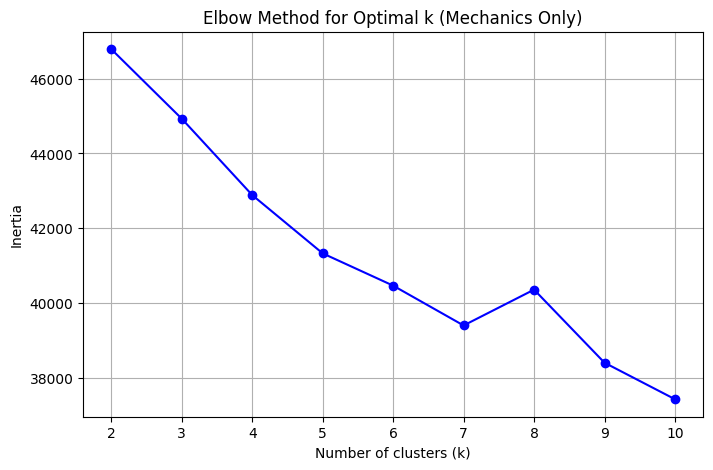

In [171]:
# Plot the elbow method result (Inertia)
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, 'o-', color='blue')
plt.title('Elbow Method for Optimal k (Mechanics Only)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

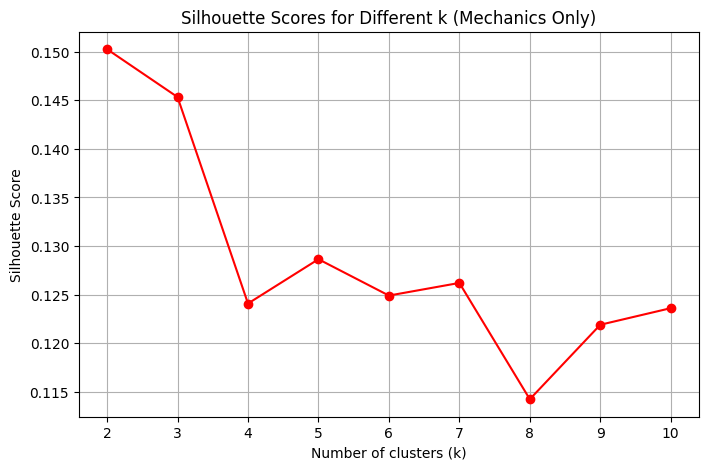

In [172]:
# Plot the silhouette scores
plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, 'o-', color='red')
plt.title('Silhouette Scores for Different k (Mechanics Only)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### Choose K from Elbow Method & all silhouette score, I see a special number "7"

In [175]:
optimal_k = 7

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans.fit(X)
df['Cluster'] = kmeans.labels_

# Evaluate the chosen clustering
final_sil_score = silhouette_score(X, df['Cluster'])
print("Final Silhouette Score with k=", optimal_k, ":", final_sil_score)

Final Silhouette Score with k= 7 : 0.1261971692337929


In [176]:
print(df['Cluster'].value_counts())

# Optional: Look at representative mechanics per cluster
# We can see which mechanics are most common in each cluster
cluster_mech_sums = pd.DataFrame(X, columns=mlb.classes_).groupby(df['Cluster']).sum()
print(cluster_mech_sums)

Cluster
1    9142
5    2670
3    2146
4    2066
2    1598
6    1506
0    1199
Name: count, dtype: int64
         Acting  Action Drafting  Action Points  Action Queue  \
Cluster                                                         
0             1                6            120            50   
1           196                8            222           166   
2             0                0             61            30   
3             5                4             59            27   
4            11                5            349            84   
5            15                0            200            27   
6             2                3             71            13   

         Action Retrieval  Action Timer  Action/Event  Advantage Token  \
Cluster                                                                  
0                      11             0            11                4   
1                      14             8             6                5   
2             

In [179]:

cluster_counts = df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
print(cluster_counts)


   Cluster  Count
0        1   9142
1        5   2670
2        3   2146
3        4   2066
4        2   1598
5        6   1506
6        0   1199


In [180]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Add the PCA components to the dataframe
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

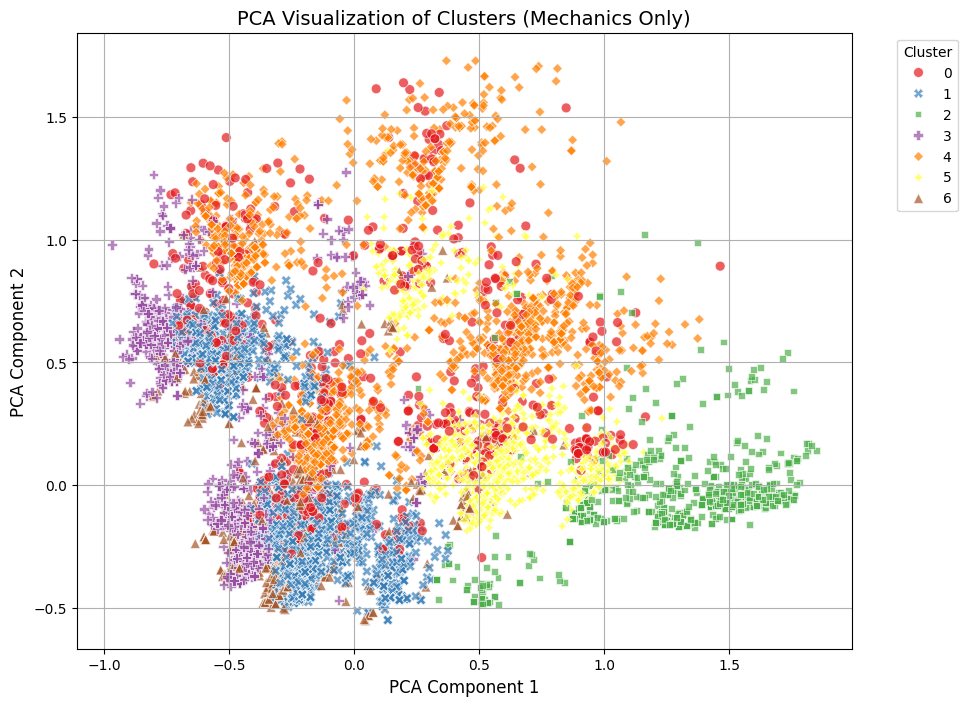

In [181]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='Set1',
    style='Cluster',
    s=50,
    alpha=0.7
)
plt.title('PCA Visualization of Clusters (Mechanics Only)', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()